# GWAS in Pharmacogenetics

Welcome to this tutorial on leveraging the power of Zarr for large-scale genomic analyses using the Sgkit Python package. In the realm of pharmacogenetics and beyond, Sgkit offers a comprehensive suite of analytical genetics methods, all seamlessly integrated with versatile frameworks like Xarray, Pandas, Dask, and Zarr.

By harnessing the capabilities of Zarr, a cutting-edge storage format, Sgkit empowers researchers to handle vast amounts of genetic data without compromising on performance or scalability. The Sgkit API is thoughtfully designed, making minimal assumptions about the source, structure, or purpose of genetic data. Instead, it adopts domain-specific conventions that seamlessly incorporate genetic data into a wider ecosystem of tools.

Whether you're delving into complex workflows over distributed datasets or stepping into the world of Python genetics analysis for the first time, Sgkit's versatility caters to your needs. The package draws inspiration from renowned Python genetics toolkits like scikit-allel and Hail, each focusing respectively on population and quantitative genetics.

As we embark on this tutorial, we'll explore how Zarr, in synergy with Sgkit, revolutionizes the landscape of large-scale genomic analyses. Let's dive into the details and discover how this powerful combination can reshape the way we approach genetics research.

# Explore VCF into a zarr format using sgkit

Zarr is a format for the storage of chunked, compressed, N-dimensional arrays inspired by HDF5, h5py and bcolz.

- Create N-dimensional arrays with any NumPy dtype.
- Chunk arrays along any dimension.
- Compress and/or filter chunks using any NumCodecs codec.
- Store arrays in memory, on disk, inside a Zip file, on S3, …
- Read an array concurrently from multiple threads or processes.
- Write to an array concurrently from multiple threads or processes.
- Organize arrays into hierarchies via groups.



**Create conda enrivonment**

```
conda create -n sgkit
```

After you successfully create an enrivonment, then type

```
conda activate sgkit
```

In [3]:
# !pip install fsspec --quiet
# !pip install scikit-allel --quiet
# !pip install zarr --quiet
# !pip install sgkit --quiet
# !pip install 'sgkit[vcf]' --quiet
# !pip install matplotlib --quiet
# !pip install seaborn  --quiet

In [1]:
import io
import os
import sys

import allel
import dask.array as da
import gzip
import numcodecs
import numpy as np
import requests
import zarr

In [2]:
url_toy_vcf = "https://github.com/jeyabbalas/vcf-to-zarr/blob/main/data/vcf/simple.vcf.gz?raw=true"
fname_toy_zarr = "toy.zarr"

In [3]:
response = requests.get(url_toy_vcf, stream=True)

allel.vcf_to_zarr(gzip.GzipFile(fileobj = io.BytesIO(response.content)),
                  fname_toy_zarr,
                  fields="*",
                  compressor=numcodecs.Blosc(cname='zstd', clevel=1, shuffle=False),
                  chunk_length=2,
                  chunk_width=1,
                  log=sys.stdout,
                  overwrite=True)

[vcf_to_zarr] 2 rows in 0.00s; chunk in 0.00s (17586 rows/s); 20 :17330
[vcf_to_zarr] 4 rows in 0.07s; chunk in 0.07s (29 rows/s); 20 :1230237
[vcf_to_zarr] 5 rows in 0.10s; chunk in 0.03s (34 rows/s); 20 :1234567
[vcf_to_zarr] all done (33 rows/s)


In [4]:
callset = zarr.open_group(fname_toy_zarr, mode="r")

In [5]:
fname_real_zarr = "toy.zarr"
callset = zarr.open_group(fname_real_zarr, mode="r")

In [6]:
callset

<zarr.hierarchy.Group '/' read-only>

In [7]:
callset["samples"]

<zarr.core.Array '/samples' (3,) object read-only>

In [8]:
callset["samples"][:]

array(['NA00001', 'NA00002', 'NA00003'], dtype=object)

In [9]:
callset["calldata/GT"]

<zarr.core.Array '/calldata/GT' (5, 3, 2) int8 read-only>

In [10]:
gt = callset["calldata/GT"]

In [11]:
gt[0]

array([[0, 0],
       [1, 0],
       [1, 1]], dtype=int8)

In [12]:
# Array of discrete genotype calls for a matrix of variants and samples.
allel.GenotypeArray(callset['calldata/GT'])

,0,1,2
0,0/0,1/0,1/1
1,0/0,0/1,0/0
2,1/2,2/1,2/2
3,0/0,0/0,0/0
4,0/1,0/2,1/1


In [13]:
simple_da = da.from_zarr(os.path.join(fname_toy_zarr, "calldata/GT/"))

In [14]:
simple_da

dask.array<from-zarr, shape=(5, 3, 2), dtype=int8, chunksize=(2, 1, 2), chunktype=numpy.ndarray>

In [15]:
simple_da[0].compute()

array([[0, 0],
       [1, 0],
       [1, 1]], dtype=int8)

In [16]:
allele_dosage = da.apply_along_axis(np.sum, -1, simple_da)

In [17]:
allele_dosage

dask.array<sum-along-axis, shape=(5, 3), dtype=int64, chunksize=(2, 1), chunktype=numpy.ndarray>

In [18]:
allele_dosage[:].compute()

array([[0, 1, 2],
       [0, 1, 0],
       [3, 3, 4],
       [0, 0, 0],
       [1, 2, 2]])

# GWAS Tutorial

This notebook is an sgkit port of Hail’s GWAS Tutorial, which demonstrates how to run a genome-wide SNP association test. Readers are encouraged to read the Hail tutorial alongside this one for more background, and to see the motivation behind some of the steps.

Note that some of the results do not exactly match the output from Hail. Also, since sgkit is still a 0.x release, its API is still subject to non-backwards compatible changes.

In [19]:
import sgkit as sg
from sgkit.io.vcf import vcf_to_zarr

Before using sgkit, we import some standard Python libraries and set the Xarray display options to not show all the attributes in a dataset by default.

In [20]:
import numpy as np
import pandas as pd
import xarray as xr
xr.set_options(display_expand_attrs=False, display_expand_data_vars=True);

# Download public 1000 Genomes data

We use the same small (20MB) portion of the public 1000 Genomes data that Hail uses.

First, download the file locally:

In [21]:
from pathlib import Path
import requests

if not Path("1kg.vcf.bgz").exists():
    response = requests.get("https://storage.googleapis.com/sgkit-gwas-tutorial/1kg.vcf.bgz")
    with open("1kg.vcf.bgz", "wb") as f:
        f.write(response.content)

# Importing data from VCF

Next, convert it to Zarr, stored on the local filesystem in a directory called 1kg.zarr.

In [22]:
vcf_to_zarr("1kg.vcf.bgz", "1kg.zarr", max_alt_alleles=1,
          fields=["FORMAT/GT", "FORMAT/DP", "FORMAT/GQ", "FORMAT/AD"],
          field_defs={"FORMAT/AD": {"Number": "R"}})

[W::bcf_hdr_check_sanity] PL should be declared as Number=G


We passed a few arguments to the vcf_to_zarr conversion function, so it only converts the first alternate allele (max_alt_alleles=1), and to load extra VCF fields we are interested in (GT, DP, GQ, and AD). Also, AD needed defining as having a Number definition of R (one value for each allele, including the reference), since the dataset we are using defines it as . which means “unknown”.

Now the data has been written as Zarr, all downstream operations on will be much faster. Note that sgkit uses an Xarray dataset to represent the VCF data, where Hail uses MatrixTable.

In [23]:
ds = sg.load_dataset("1kg.zarr")

Getting to know our data
To start with we’ll look at some summary data from the dataset.

The simplest thing is to look at the dimensions and data variables in the Xarray dataset.



In [24]:
ds

<xarray.Dataset>
Dimensions:               (variants: 10879, samples: 284, alleles: 2,
                           ploidy: 2, contigs: 84, filters: 1)
Dimensions without coordinates: variants, samples, alleles, ploidy, contigs,
                                filters
Data variables: (12/17)
    call_AD               (variants, samples, alleles) int32 dask.array<chunksize=(10000, 284, 2), meta=np.ndarray>
    call_DP               (variants, samples) int32 dask.array<chunksize=(10000, 284), meta=np.ndarray>
    call_GQ               (variants, samples) int32 dask.array<chunksize=(10000, 284), meta=np.ndarray>
    call_genotype         (variants, samples, ploidy) int8 dask.array<chunksize=(10000, 284, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool dask.array<chunksize=(10000, 284, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool dask.array<chunksize=(10000, 284), meta=np.ndarray>
    ...                    ...
    variant_contig        (variants) int8 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_filter        (variants, filters) bool dask.array<chunksize=(10000, 1), meta=np.ndarray>
    variant_id            (variants) object dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_id_mask       (variants) bool dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_position      (variants) int32 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_quality       (variants) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
Attributes: (7)

Next we’ll use display_genotypes to show the the first and last few variants and samples.

Note: sgkit does not store the contig names in an easily accessible form, so we compute a variable variant_contig_name in the same dataset storing them for later use, and set an index so we can see the variant name, position, and ID.

In [25]:
ds["variant_contig_name"] = ds.contig_id[ds.variant_contig]
ds2 = ds.set_index({"variants": ("variant_contig_name", "variant_position", "variant_id")})
sg.display_genotypes(ds2, max_variants=10, max_samples=5)

samples,HG00096,HG00099,...,NA21133,NA21143
variants,,,,,
"(1, 904165, .)",0/0,0/0,...,0/0,0/0
"(1, 909917, .)",0/0,0/0,...,0/0,0/0
"(1, 986963, .)",0/0,0/0,...,0/0,0/0
"(1, 1563691, .)",./.,0/0,...,0/0,0/0
"(1, 1707740, .)",0/1,0/1,...,0/1,0/0
...,...,...,...,...,...
"(X, 152660491, .)",./.,0/0,...,1/1,0/0
"(X, 153031688, .)",0/0,0/0,...,0/0,0/0
"(X, 153674876, .)",0/0,0/0,...,0/0,0/0


We can show the alleles too.

Note: this needs work to make it easier to do

In [26]:
df_variant = ds[[v for v in ds.data_vars if v.startswith("variant_")]].to_dataframe()
df_variant.groupby(["variant_contig_name", "variant_position", "variant_id"]).agg({"variant_allele": lambda x: list(x)}).head(5)

variant_allele
variant_contig_name variant_position variant_id               
1                   904165           .                  [G, A]
                    909917           .                  [G, A]
                    986963           .                  [C, T]
                    1563691          .                  [T, G]
                    1707740          .                  [T, G]

Show the first five sample IDs by referencing the dataset variable directly:

In [31]:
ds.sample_id[:5].values

array(['HG00096', 'HG00099', 'HG00105', 'HG00118', 'HG00129'],
      dtype=object)

# Adding column fields
Xarray datasets can have any number of variables added to them, possibly loaded from different sources. Next we’ll take a text file (CSV) containing annotations, and use it to annotate the samples in the dataset.

First we load the annotation data using regular Pandas.

In [32]:
ANNOTATIONS_FILE = "https://storage.googleapis.com/sgkit-gwas-tutorial/1kg_annotations.txt"
df = pd.read_csv(ANNOTATIONS_FILE, sep="\t", index_col="Sample")

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3500 entries, HG00096 to NA21144
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Population           3500 non-null   object
 1   SuperPopulation      3500 non-null   object
 2   isFemale             3500 non-null   bool  
 3   PurpleHair           3500 non-null   bool  
 4   CaffeineConsumption  3500 non-null   int64 
dtypes: bool(2), int64(1), object(2)
memory usage: 116.2+ KB


In [36]:
df

,Population,SuperPopulation,isFemale,PurpleHair,CaffeineConsumption
Sample,,,,,
HG00096,GBR,EUR,False,False,4
HG00097,GBR,EUR,True,True,4
HG00098,GBR,EUR,False,False,5
HG00099,GBR,EUR,True,False,4
HG00100,GBR,EUR,True,False,5
...,...,...,...,...,...
NA21137,GIH,SAS,True,False,1
NA21141,GIH,SAS,True,True,2
NA21142,GIH,SAS,True,True,2


To join the annotation data with the genetic data, we convert it to Xarray, then do a join.

In [37]:
ds_annotations = pd.DataFrame.to_xarray(df).rename({"Sample":"samples"})
ds = ds.set_index({"samples": "sample_id"})
ds = ds.merge(ds_annotations, join="left")
ds = ds.reset_index("samples").reset_coords(drop=True)
ds

<xarray.Dataset>
Dimensions:               (samples: 284, variants: 10879, alleles: 2,
                           ploidy: 2, contigs: 84, filters: 1)
Dimensions without coordinates: samples, variants, alleles, ploidy, contigs,
                                filters
Data variables: (12/22)
    call_AD               (variants, samples, alleles) int32 dask.array<chunksize=(10000, 284, 2), meta=np.ndarray>
    call_DP               (variants, samples) int32 dask.array<chunksize=(10000, 284), meta=np.ndarray>
    call_GQ               (variants, samples) int32 dask.array<chunksize=(10000, 284), meta=np.ndarray>
    call_genotype         (variants, samples, ploidy) int8 dask.array<chunksize=(10000, 284, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool dask.array<chunksize=(10000, 284, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool dask.array<chunksize=(10000, 284), meta=np.ndarray>
    ...                    ...
    variant_contig_name   (variants) <U10 dask.array<chunksize=(10000,), meta=np.ndarray>
    Population            (samples) object 'GBR' 'GBR' 'GBR' ... 'GIH' 'GIH'
    SuperPopulation       (samples) object 'EUR' 'EUR' 'EUR' ... 'SAS' 'SAS'
    isFemale              (samples) bool False True False ... False False True
    PurpleHair            (samples) bool False False False ... False True True
    CaffeineConsumption   (samples) int64 4 4 4 3 6 2 4 2 1 ... 5 6 4 6 4 6 5 5
Attributes: (7)

# Query functions

We can look at some statistics of the data by converting the relevant dataset variable to a Pandas series, then using its built-in summary functions. Annotation data is usually small enough to load into memory, which is why it’s OK using Pandas here.

Here’s the population distribution by continent:

In [39]:
ds_annotations.SuperPopulation.to_series().value_counts()

SuperPopulation
AFR    1018
EUR     669
SAS     661
EAS     617
AMR     535
Name: count, dtype: int64

The distribution of the CaffeineConsumption variable:

In [40]:
ds_annotations.CaffeineConsumption.to_series().describe()

count    3500.000000
mean        3.983714
std         1.702349
min        -1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        10.000000
Name: CaffeineConsumption, dtype: float64

There are far fewer samples in our dataset than the full 1000 genomes dataset, as we can see from the following queries.

In [42]:
len(ds_annotations.samples)

3500

In [43]:
ds.CaffeineConsumption.to_series().describe()

count    284.000000
mean       4.415493
std        1.580549
min        0.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        9.000000
Name: CaffeineConsumption, dtype: float64

Here’s an example of doing an ad hoc query to uncover a biological insight from the data: calculate the counts of each of the 12 possible unique SNPs (4 choices for the reference base * 3 choices for the alternate base).

In [44]:
df_variant.groupby(["variant_contig_name", "variant_position", "variant_id"])["variant_allele"].apply(tuple).value_counts()

variant_allele
(C, T)    2418
(G, A)    2367
(A, G)    1929
(T, C)    1864
(C, A)     494
(G, T)     477
(T, G)     466
(A, C)     451
(C, G)     150
(G, C)     111
(T, A)      77
(A, T)      75
Name: count, dtype: int64

Often we want to plot the data, to get a feel for how it’s distributed. Xarray has some convenience functions for plotting, which we use here to show the distribution of the DP field.

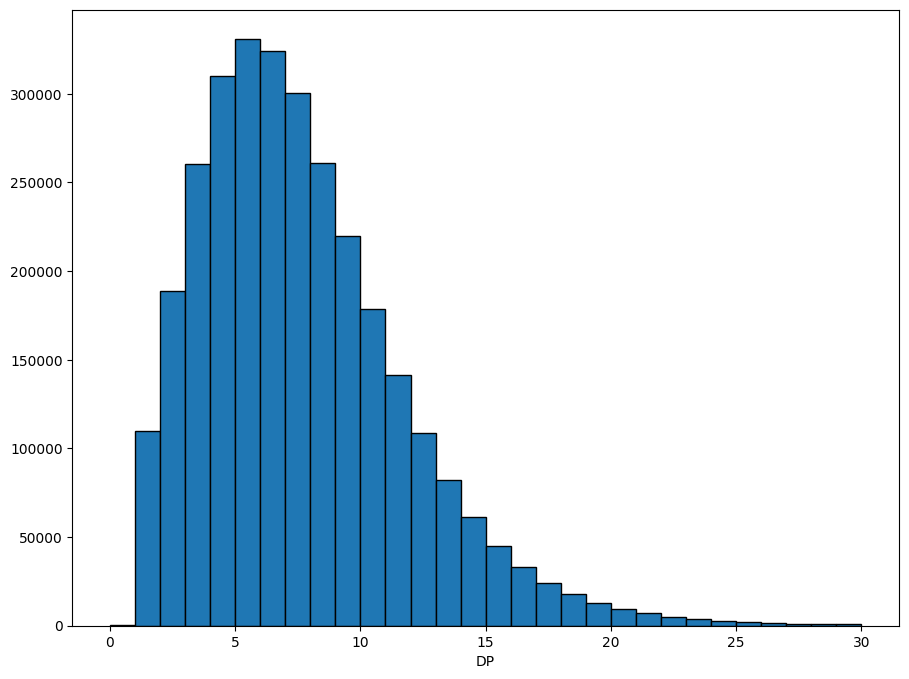

In [41]:
dp = ds.call_DP.where(ds.call_DP >= 0) # filter out missing
dp.attrs["long_name"] = "DP"
xr.plot.hist(dp, range=(0, 30), bins=30, size=8, edgecolor="black");

# Quality control

QC is the process of filtering out poor quality data before running an analysis. This is usually an iterative process.

The sample_stats function in sgkit computes a collection of useful metrics for each sample and stores them in new variables. (The Hail equivalent is sample_qc.)

Here’s the dataset before running sample_stats.

In [45]:
ds

<xarray.Dataset>
Dimensions:               (samples: 284, variants: 10879, alleles: 2,
                           ploidy: 2, contigs: 84, filters: 1)
Dimensions without coordinates: samples, variants, alleles, ploidy, contigs,
                                filters
Data variables: (12/22)
    call_AD               (variants, samples, alleles) int32 dask.array<chunksize=(10000, 284, 2), meta=np.ndarray>
    call_DP               (variants, samples) int32 dask.array<chunksize=(10000, 284), meta=np.ndarray>
    call_GQ               (variants, samples) int32 dask.array<chunksize=(10000, 284), meta=np.ndarray>
    call_genotype         (variants, samples, ploidy) int8 dask.array<chunksize=(10000, 284, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool dask.array<chunksize=(10000, 284, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool dask.array<chunksize=(10000, 284), meta=np.ndarray>
    ...                    ...
    variant_contig_name   (variants) <U10 dask.array<chunksize=(10000,), meta=np.ndarray>
    Population            (samples) object 'GBR' 'GBR' 'GBR' ... 'GIH' 'GIH'
    SuperPopulation       (samples) object 'EUR' 'EUR' 'EUR' ... 'SAS' 'SAS'
    isFemale              (samples) bool False True False ... False False True
    PurpleHair            (samples) bool False False False ... False True True
    CaffeineConsumption   (samples) int64 4 4 4 3 6 2 4 2 1 ... 5 6 4 6 4 6 5 5
Attributes: (7)

We can see the new variables (with names beginning sample_) after we run sample_stats:

In [46]:
ds = sg.sample_stats(ds)
ds

<xarray.Dataset>
Dimensions:               (samples: 284, variants: 10879, alleles: 2,
                           ploidy: 2, contigs: 84, filters: 1)
Dimensions without coordinates: samples, variants, alleles, ploidy, contigs,
                                filters
Data variables: (12/28)
    sample_n_called       (samples) int64 dask.array<chunksize=(284,), meta=np.ndarray>
    sample_call_rate      (samples) float64 dask.array<chunksize=(284,), meta=np.ndarray>
    sample_n_het          (samples) int64 dask.array<chunksize=(284,), meta=np.ndarray>
    sample_n_hom_ref      (samples) int64 dask.array<chunksize=(284,), meta=np.ndarray>
    sample_n_hom_alt      (samples) int64 dask.array<chunksize=(284,), meta=np.ndarray>
    sample_n_non_ref      (samples) int64 dask.array<chunksize=(284,), meta=np.ndarray>
    ...                    ...
    variant_contig_name   (variants) <U10 dask.array<chunksize=(10000,), meta=np.ndarray>
    Population            (samples) object 'GBR' 'GBR' 'GBR' ... 'GIH' 'GIH'
    SuperPopulation       (samples) object 'EUR' 'EUR' 'EUR' ... 'SAS' 'SAS'
    isFemale              (samples) bool False True False ... False False True
    PurpleHair            (samples) bool False False False ... False True True
    CaffeineConsumption   (samples) int64 4 4 4 3 6 2 4 2 1 ... 5 6 4 6 4 6 5 5
Attributes: (7)

We can plot the metrics next.

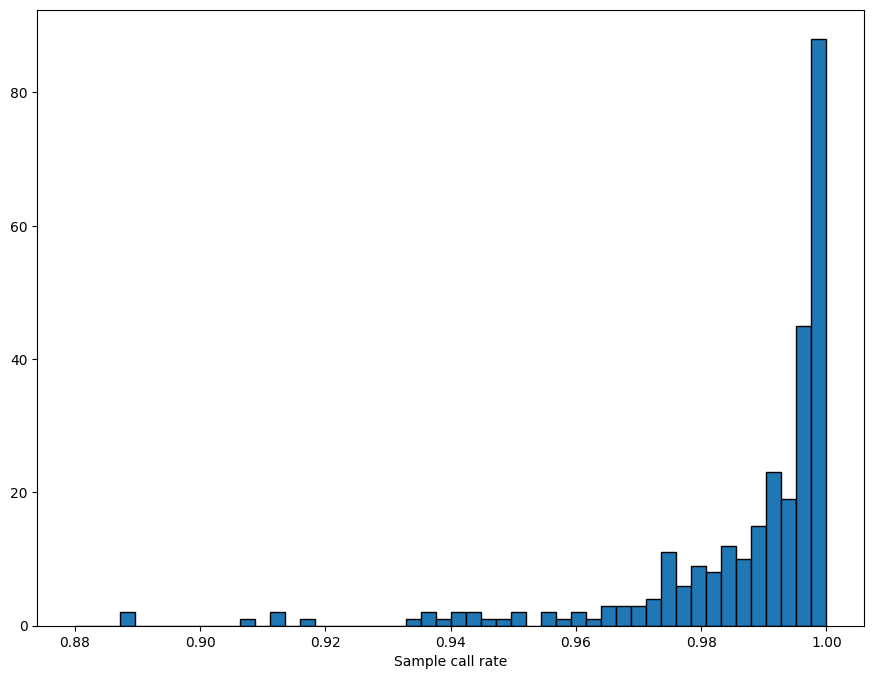

In [44]:
ds.sample_call_rate.attrs["long_name"] = "Sample call rate"
xr.plot.hist(ds.sample_call_rate, range=(.88,1), bins=50, size=8, edgecolor="black");

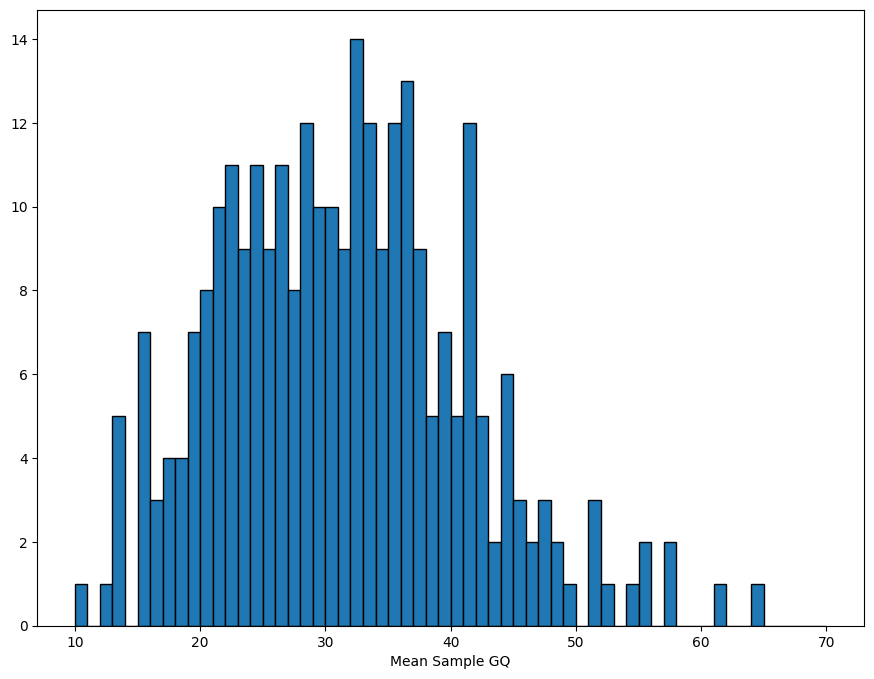

In [45]:
gq = ds.call_GQ.where(ds.call_GQ >= 0) # filter out missing
sample_gq_mean = gq.mean(dim="variants")
sample_gq_mean.attrs["long_name"] = "Mean Sample GQ"
xr.plot.hist(sample_gq_mean, range=(10,70), bins=60, size=8, edgecolor="black");

In [47]:
dp = ds.call_DP.where(ds.call_DP >= 0) # filter out missing
sample_dp_mean = dp.mean(dim="variants")
sample_dp_mean.attrs["long_name"] = "Mean Sample DP"
ds["sample_dp_mean"] = sample_dp_mean # add new data array to dataset

The following removes outliers using an arbitrary cutoff.

In [48]:
ds.sel(samples=((ds.sample_dp_mean.compute() >= 4) & (ds.sample_call_rate.compute() >= 0.97)))

<xarray.Dataset>
Dimensions:               (samples: 250, variants: 10879, alleles: 2,
                           ploidy: 2, contigs: 84, filters: 1)
Dimensions without coordinates: samples, variants, alleles, ploidy, contigs,
                                filters
Data variables: (12/29)
    sample_n_called       (samples) int64 dask.array<chunksize=(250,), meta=np.ndarray>
    sample_call_rate      (samples) float64 dask.array<chunksize=(250,), meta=np.ndarray>
    sample_n_het          (samples) int64 dask.array<chunksize=(250,), meta=np.ndarray>
    sample_n_hom_ref      (samples) int64 dask.array<chunksize=(250,), meta=np.ndarray>
    sample_n_hom_alt      (samples) int64 dask.array<chunksize=(250,), meta=np.ndarray>
    sample_n_non_ref      (samples) int64 dask.array<chunksize=(250,), meta=np.ndarray>
    ...                    ...
    Population            (samples) object 'GBR' 'GBR' 'GBR' ... 'GIH' 'GIH'
    SuperPopulation       (samples) object 'EUR' 'EUR' 'EUR' ... 'SAS' 'SAS'
    isFemale              (samples) bool False True False ... False False True
    PurpleHair            (samples) bool False False False ... False True True
    CaffeineConsumption   (samples) int64 4 4 4 3 6 2 2 5 5 ... 5 6 4 6 4 6 5 5
    sample_dp_mean        (samples) float64 dask.array<chunksize=(250,), meta=np.ndarray>
Attributes: (7)

In [49]:
ds = ds.sel(samples=((ds.sample_dp_mean.compute() >= 4) & (ds.sample_call_rate.compute() >= 0.97)))
print(f"After filter, {len(ds.samples)}/284 samples remain.")

After filter, 250/284 samples remain.


Genotype QC is more complicated. First we calculate a variable ab, which is the fraction of reads that were the alternate allele.

In [50]:
# fill rows with nan where no alternate alleles were read or where sum of reads is 0
ad1 = ds.call_AD.sel(dict(alleles=1)).pipe(lambda v: v.where(v >= 0))
adsum = ds.call_AD.sum(dim="alleles").pipe(lambda v: v.where(v != 0))
# compute alternate allele read fraction
ab = ad1 / adsum

Then we can use the ab variable in the filter condition, to filter homozygous reference calls with >10% alternate reads, homozygous alternate calls with >10% reference reads, or heterozygote calls without a ref/alt balance near 50%.

In [51]:
GT = ds.call_genotype
hom_ref = (GT == 0).all(dim="ploidy")
het = GT[..., 0] != GT[..., 1]
hom_alt = ((GT > 0) & (GT[..., 0] == GT)).all(dim="ploidy")
filter_condition_ab = ((hom_ref & (ab <= 0.1)) |
                        (het & (ab >= 0.25) & (ab <= 0.75)) |
                        (hom_alt & (ab >= 0.9)))

In [52]:
filter_mask = xr.where(ds.call_genotype_mask, True, filter_condition_ab)
fraction_filtered = GT.where(~filter_mask).count().values / GT.size
print(f"Filtering {fraction_filtered * 100:.2f}% entries out of downstream analysis.")

Filtering 3.65% entries out of downstream analysis.


Note: genotype QC is filtering out slightly different numbers of entries compared to the Hail tutorial.

Variant QC is similar. This time we use the variant_stats function, but we won’t do any filtering on these variables.

In [53]:
ds = sg.variant_stats(ds)
ds

<xarray.Dataset>
Dimensions:                   (variants: 10879, alleles: 2, samples: 250,
                               ploidy: 2, contigs: 84, filters: 1)
Dimensions without coordinates: variants, alleles, samples, ploidy, contigs,
                                filters
Data variables: (12/38)
    variant_n_called          (variants) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_call_rate         (variants) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_n_het             (variants) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_n_hom_ref         (variants) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_n_hom_alt         (variants) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_n_non_ref         (variants) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
    ...                        ...
    Population                (samples) object 'GBR' 'GBR' 'GBR' ... 'GIH' 'GIH'
    SuperPopulation           (samples) object 'EUR' 'EUR' 'EUR' ... 'SAS' 'SAS'
    isFemale                  (samples) bool False True False ... False True
    PurpleHair                (samples) bool False False False ... True True
    CaffeineConsumption       (samples) int64 4 4 4 3 6 2 2 5 ... 6 4 6 4 6 5 5
    sample_dp_mean            (samples) float64 dask.array<chunksize=(250,), meta=np.ndarray>
Attributes: (7)

# Let’s do a GWAS!

First we need to restrict to common variants (1% cutoff), and not far from Hardy-Weinberg equilibrium.

In [54]:
ds = sg.hardy_weinberg_test(ds)

In [55]:
ds

<xarray.Dataset>
Dimensions:                   (variants: 10879, genotypes: 3, alleles: 2,
                               samples: 250, ploidy: 2, contigs: 84, filters: 1)
Coordinates:
  * genotypes                 (genotypes) <U3 '0/0' '0/1' '1/1'
Dimensions without coordinates: variants, alleles, samples, ploidy, contigs,
                                filters
Data variables: (12/41)
    variant_hwe_p_value       (variants) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_genotype_count    (variants, genotypes) uint64 dask.array<chunksize=(10000, 3), meta=np.ndarray>
    genotype_id               (genotypes) <U3 dask.array<chunksize=(3,), meta=np.ndarray>
    variant_n_called          (variants) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_call_rate         (variants) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_n_het             (variants) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
    ...                        ...
    Population                (samples) object 'GBR' 'GBR' 'GBR' ... 'GIH' 'GIH'
    SuperPopulation           (samples) object 'EUR' 'EUR' 'EUR' ... 'SAS' 'SAS'
    isFemale                  (samples) bool False True False ... False True
    PurpleHair                (samples) bool False False False ... True True
    CaffeineConsumption       (samples) int64 4 4 4 3 6 2 2 5 ... 6 4 6 4 6 5 5
    sample_dp_mean            (samples) float64 dask.array<chunksize=(250,), meta=np.ndarray>
Attributes: (7)

In [56]:
ds = ds.sel(variants=((ds.variant_allele_frequency.compute()[:,1] > 0.01) & (ds.variant_hwe_p_value.compute() > 1e-6)))


Note: again, the number of variants is different to the Hail tutorial, but the final results work out to be very similar.

In [58]:
print(f"Samples: {len(ds.samples)}  Variants: {len(ds.variants)}")


Samples: 250  Variants: 8394


Run a linear regression of dosage (number of alt alleles) against the CaffeineConsumption trait.



In [59]:
ds["call_dosage"] = ds.call_genotype.sum(dim="ploidy")
ds_lr = sg.gwas_linear_regression(ds, dosage="call_dosage",
                                  add_intercept=True, covariates=[], traits=["CaffeineConsumption"])
ds_lr

<xarray.Dataset>
Dimensions:                   (variants: 8394, traits: 1, genotypes: 3,
                               alleles: 2, samples: 250, ploidy: 2,
                               contigs: 84, filters: 1)
Coordinates:
  * genotypes                 (genotypes) <U3 '0/0' '0/1' '1/1'
Dimensions without coordinates: variants, traits, alleles, samples, ploidy,
                                contigs, filters
Data variables: (12/45)
    variant_linreg_beta       (variants, traits) float64 dask.array<chunksize=(7918, 1), meta=np.ndarray>
    variant_linreg_t_value    (variants, traits) float64 dask.array<chunksize=(7918, 1), meta=np.ndarray>
    variant_linreg_p_value    (variants, traits) float64 dask.array<chunksize=(7918, 1), meta=np.ndarray>
    variant_hwe_p_value       (variants) float64 dask.array<chunksize=(7918,), meta=np.ndarray>
    variant_genotype_count    (variants, genotypes) uint64 dask.array<chunksize=(7918, 3), meta=np.ndarray>
    genotype_id               (genotypes) <U3 dask.array<chunksize=(3,), meta=np.ndarray>
    ...                        ...
    SuperPopulation           (samples) object 'EUR' 'EUR' 'EUR' ... 'SAS' 'SAS'
    isFemale                  (samples) bool False True False ... False True
    PurpleHair                (samples) bool False False False ... True True
    CaffeineConsumption       (samples) int64 4 4 4 3 6 2 2 5 ... 6 4 6 4 6 5 5
    sample_dp_mean            (samples) float64 dask.array<chunksize=(250,), meta=np.ndarray>
    call_dosage               (variants, samples) int64 dask.array<chunksize=(7918, 250), meta=np.ndarray>
Attributes: (7)

You can see that new variables have been added for variant_linreg_p_value, variant_linreg_t_value, and variant_linreg_beta.

Since sgkit doesn’t have any plotting utilities, we implement Manhattan plots and QQ plots here using Seaborn.

In [60]:
import seaborn as sns
%matplotlib inline

In [61]:
def manhattan_plot(ds):
    df = ds[["variant_contig_name", "variant_contig", "variant_position", "variant_linreg_p_value"]].to_dataframe()
    df["variant_linreg_log_p_value"] = -np.log10(df["variant_linreg_p_value"])
    df = df.astype({"variant_position": np.int64}) # to avoid overflow in cumulative_pos

    # from https://github.com/mojones/video_notebooks/blob/master/Manhattan%20plots%20in%20Python.ipynb, cell 20
    running_pos = 0
    cumulative_pos = []
    for chrom, group_df in df.groupby("variant_contig"):
        cumulative_pos.append(group_df["variant_position"] + running_pos)
        running_pos += group_df["variant_position"].max()
    df["cumulative_pos"] = pd.concat(cumulative_pos)

    df["color group"] = df["variant_contig"].apply(lambda x : "A" if x % 2 == 0 else "B")

    g = sns.relplot(
        data = df,
        x = "cumulative_pos",
        y = "variant_linreg_log_p_value",
        hue = "color group",
        palette = ["blue", "orange"],
        linewidth=0,
        s=10,
        legend=None,
        aspect=3
    )
    g.ax.set_xlabel("Chromosome")
    g.ax.set_xticks(df.groupby("variant_contig")["cumulative_pos"].median())
    g.ax.set_xticklabels(df["variant_contig_name"].unique())

/Users/joonan/miniconda3/envs/sgkit/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


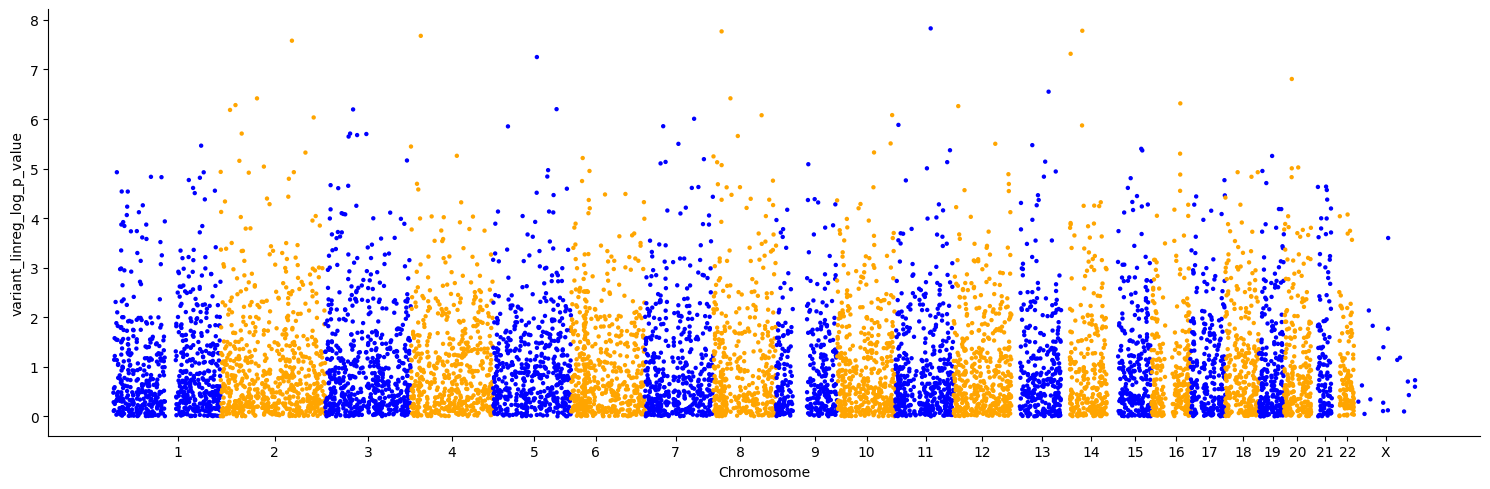

In [61]:
manhattan_plot(ds_lr)

In [62]:
import math
import matplotlib.pyplot as plt

def qq_plot(ds):
    p = ds["variant_linreg_p_value"].squeeze().values
    p.sort()
    n = len(p)
    expected_p = -np.log10(np.arange(1, n + 1) / n)
    observed_p = -np.log10(p)
    max_val = math.ceil(max(np.max(expected_p), np.max(observed_p)))

    df = pd.DataFrame({"Expected -log10(p)": expected_p, "Observed -log10(p)": observed_p})

    fig, ax = plt.subplots(figsize=(12, 12));
    g = sns.scatterplot(data=df, x="Expected -log10(p)", y="Observed -log10(p)", ax=ax, linewidth=0)

    x_pred = np.linspace(0, max_val, 50)
    sns.lineplot(x=x_pred, y=x_pred, ax=ax)

    g.set(xlim=(0, max_val), ylim=(0, max_val))

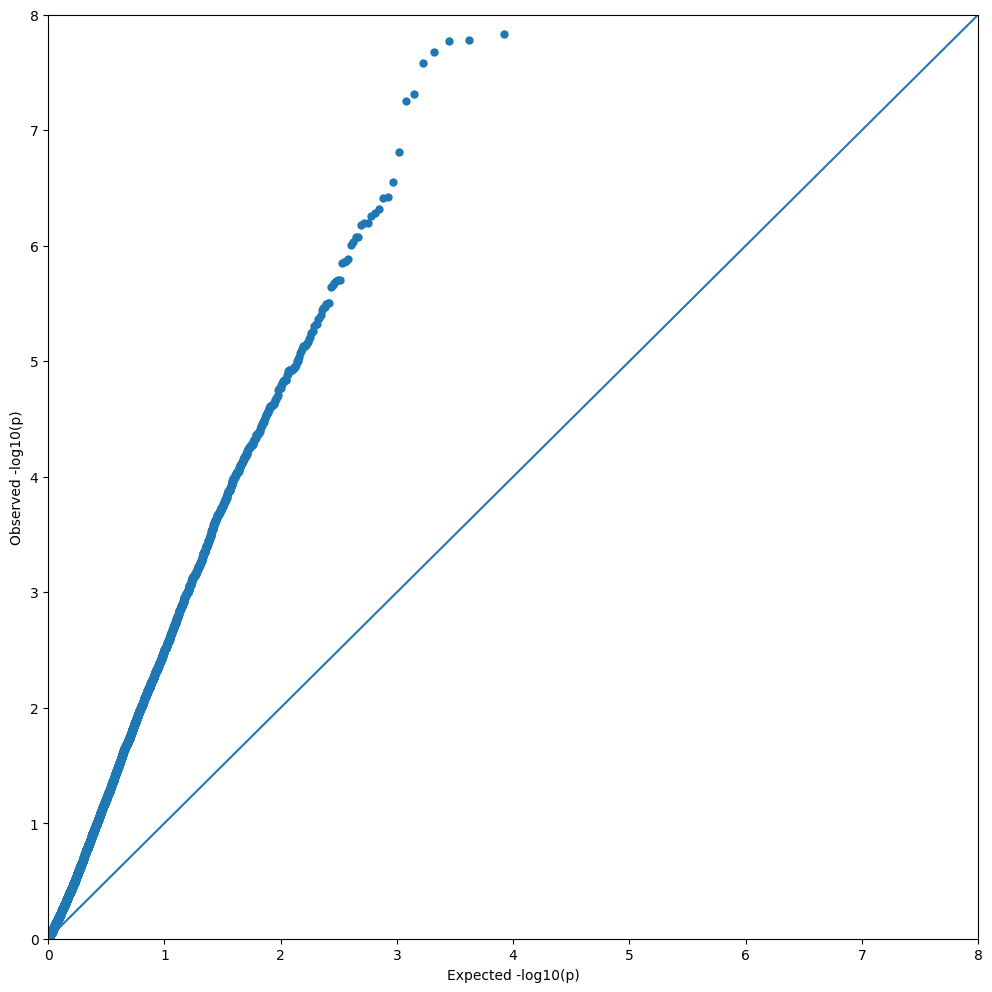

In [63]:
qq_plot(ds_lr)

# Confounding issue

As explained in the Hail tutorial, the data contains a confounder, so it is necessary to include ancestry as a covariate in the linear regression.

Rather than just use the reported ancestry, it’s better to use principal components from running a PCA on the data.

In [63]:
ds_pca = sg.stats.pca.count_call_alternate_alleles(ds)


To run PCA we need to filter out variants with any missing alt allele counts or where the counts are zero for all samples

In [64]:
variant_mask = ((ds_pca.call_alternate_allele_count.compute() < 0).any(dim="samples")) | \
    (ds_pca.call_alternate_allele_count.std(dim="samples").compute() <= 0.0)
ds_pca = ds_pca.sel(variants=~variant_mask)

In [65]:
ds_pca = sg.pca(ds_pca)

In [66]:
ds_pca.sample_pca_projection.values

array([[ -8.453593 , -26.128803 , -11.008165 , ..., -14.801218 ,
         24.537298 ,  -1.0794905],
       [ -9.496217 , -26.319609 , -10.116499 , ...,   1.6827638,
          7.6817026,  -5.957279 ],
       [ -7.873405 , -25.404314 ,  -9.85919  , ...,   4.382868 ,
         -9.368457 ,   6.3843384],
       ...,
       [-10.974407 , -11.576625 ,  20.12465  , ...,  -4.421063 ,
         -0.5393099,   1.0124542],
       [-10.754403 , -11.414771 ,  15.358786 , ...,   1.7951624,
          3.4263654,  -7.985675 ],
       [-13.062882 , -11.688103 ,  16.351276 , ...,  -7.205048 ,
         -1.7339789,   5.1750174]], dtype=float32)

In [67]:
ds_pca

<xarray.Dataset>
Dimensions:                              (samples: 250, components: 10,
                                          variants: 3491, genotypes: 3,
                                          alleles: 2, ploidy: 2, contigs: 84,
                                          filters: 1)
Coordinates:
  * genotypes                            (genotypes) <U3 '0/0' '0/1' '1/1'
Dimensions without coordinates: samples, components, variants, alleles, ploidy,
                                contigs, filters
Data variables: (12/48)
    sample_pca_projection                (samples, components) float32 dask.array<chunksize=(250, 10), meta=np.ndarray>
    sample_pca_component                 (variants, components) float32 dask.array<chunksize=(3325, 10), meta=np.ndarray>
    sample_pca_explained_variance        (components) float32 dask.array<chunksize=(10,), meta=np.ndarray>
    sample_pca_explained_variance_ratio  (components) float32 dask.array<chunksize=(10,), meta=np.ndarray>
    sample_pca_loading                   (variants, components) float32 dask.array<chunksize=(3325, 10), meta=np.ndarray>
    call_alternate_allele_count          (variants, samples) int16 dask.array<chunksize=(3325, 250), meta=np.ndarray>
    ...                                   ...
    SuperPopulation                      (samples) object 'EUR' 'EUR' ... 'SAS'
    isFemale                             (samples) bool False True ... True
    PurpleHair                           (samples) bool False False ... True
    CaffeineConsumption                  (samples) int64 4 4 4 3 6 ... 6 4 6 5 5
    sample_dp_mean                       (samples) float64 dask.array<chunksize=(250,), meta=np.ndarray>
    call_dosage                          (variants, samples) int64 dask.array<chunksize=(3325, 250), meta=np.ndarray>
Attributes: (7)

Let’s plot the first two components. Notice how they cluster by ancestry.

In [68]:
ds_pca["sample_pca_projection_0"] = ds_pca.sample_pca_projection[:,0]
ds_pca["sample_pca_projection_1"] = ds_pca.sample_pca_projection[:,1]
ds_pca["sample_pca_projection_2"] = ds_pca.sample_pca_projection[:,2]
# ds_pca.plot.scatter(x="sample_pca_projection_0", y="sample_pca_projection_1", hue="SuperPopulation", size=8, s=10);

Now we can rerun our linear regression, controlling for sample sex and the first few principal components.

In [69]:
# copy pca components back to dataset with full set of variants to run linear regression again
ds["sample_pca_projection_0"] = ds_pca.sample_pca_projection[:,0]
ds["sample_pca_projection_1"] = ds_pca.sample_pca_projection[:,1]
ds["sample_pca_projection_2"] = ds_pca.sample_pca_projection[:,2]
ds_lr = sg.gwas_linear_regression(ds, dosage="call_dosage",
                                  add_intercept=True,
                                  covariates=["isFemale", "sample_pca_projection_0", "sample_pca_projection_1", "sample_pca_projection_2"],
                                  traits=["CaffeineConsumption"])

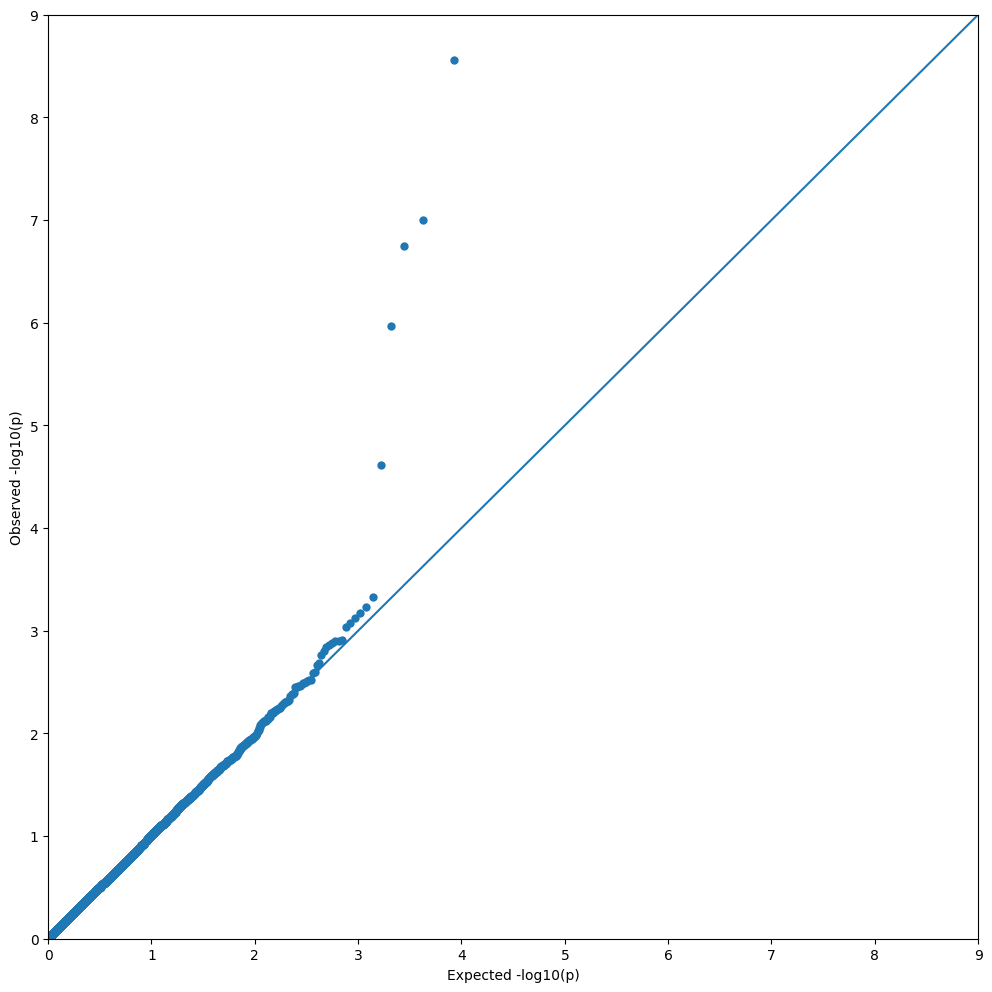

In [70]:
qq_plot(ds_lr)

/Users/joonan/miniconda3/envs/sgkit/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


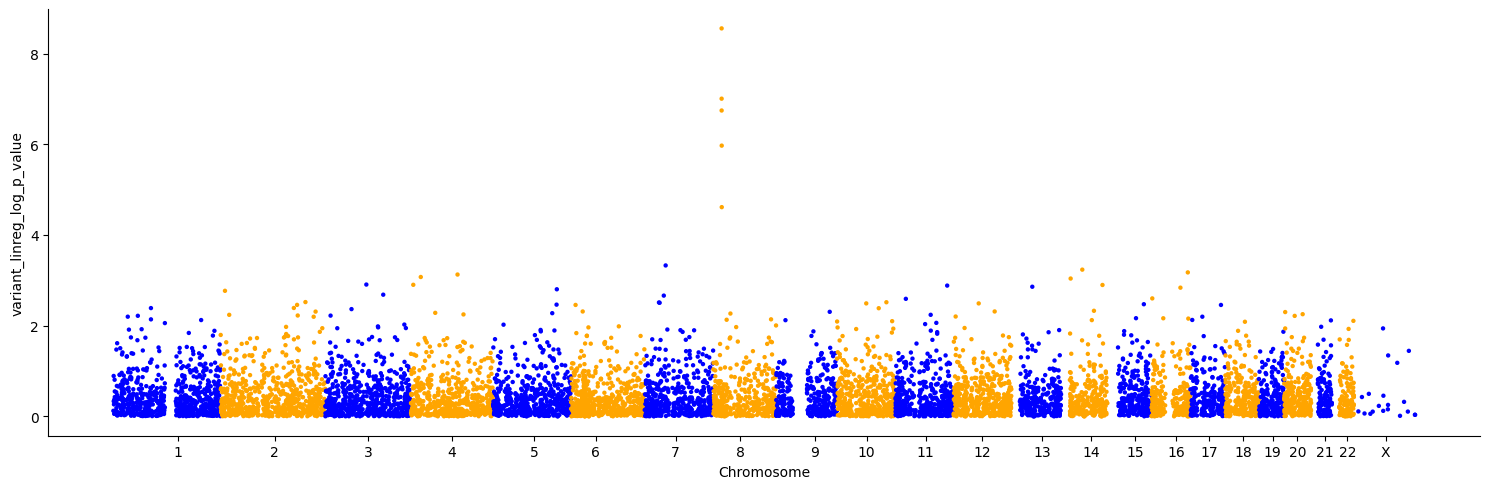

In [71]:
manhattan_plot(ds_lr)

The “caffeine consumption” locus in chromosome 8 is clearly apparent, just like in the Hail tutorial.